In [260]:
import pandas as pd
import numpy as np
import math
import json
from datetime import datetime
import re
import os
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
% matplotlib inline
from matplotlib import pyplot

# Part 1: Importing and Understanding

In [264]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Let's first see what the data looks like

In [265]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


## Here, channels are the medium through which offers are distributed and all the features related to an offer type are given

In [266]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


## Profile data contains the information specific to customers, such as their age and gender

In [267]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


## Transcript is the data that maintains what offers were being received, viewed and completed and by whom along with the transactions taking place in the application

# Part -2: Cleaning and Pre-processing
### We will start cleaning and basic pre-processing required in each of the dataframes that we have

In [268]:
# cleaning and processing portfolio data 
# first hot-encode the offer_type information into: bogo, discount and informational offer columns
offertype_data = pd.get_dummies(portfolio['offer_type'])

#next we will use label binariser as the information regarding channels is present as an array instead of single values
binariser = MultiLabelBinarizer()
binariser.fit(portfolio['channels'])
channels_data = pd.DataFrame(binariser.transform(portfolio['channels']),columns=binariser.classes_)

#we will combine the columns created until now
portfolio = pd.concat([portfolio, offertype_data, channels_data], axis=1)

# renaming id as offer id to avoid confusion with customer id
portfolio['offerid']=portfolio['id']

# dropping unnecessary columns
portfolio = portfolio.drop(columns=['id','offer_type', 'channels'])

columns_list = ['offerid','difficulty', 'duration','reward']
columns_list.extend(offertype_data.columns.values)
columns_list.extend(channels_data.columns.values)
portfolio = portfolio[columns_list]


In [269]:
portfolio.head()

,offerid,difficulty,duration,reward,bogo,discount,informational,email,mobile,social,web
0,ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,1,0,0,1,1,1,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,10,1,0,0,1,1,1,1
2,3f207df678b143eea3cee63160fa8bed,0,4,0,0,0,1,1,1,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,5,1,0,0,1,1,0,1
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5,0,1,0,1,0,0,1


In [270]:
# cleaning and processing profile data 

#defining two functions to transform the joining date and age into different groups

def define_membership(item):
    """
    :param item: each element of the column of the dataframe
    :return: transformed membership: recent/established/old
    """
    date = datetime.strptime(str(item), '%Y%m%d')
    if date.year >= 2016:
        return "recent_customers"
    elif date.year > 2014:
        return "established_customers"
    else:
        return "old_customers"
    
def define_age_group(age):
    """
    :param item: each element of the column of the dataframe
    :return: transformed age group: old/matured/millenial/teen
    """
    if age>70:
        return "old_age"
    elif age>30:
        return "matured_age"
    elif age>20:
        return "millenial_age"
    else:
        return "teen_age"
    
# first we will clear any rows that have missing values of income and gender    
profile = profile[profile['income'].notnull()]
profile = profile[profile['gender'] != 'O']
# the first element having income and gender has gender 'F', in the processed profile data, we will see that the first binary value of gender is 0 => 0 denotes female and 1 denotes male

profile = profile.reset_index(drop=True)

#binarising the gender values
binariser = LabelBinarizer()
profile['gender'] = binariser.fit_transform(profile['gender'])

#transforming the joining date column
profile['became_member_on'] = profile['became_member_on'].apply(define_membership)
membership_data = pd.get_dummies(profile['became_member_on'])

#transforming the age column
profile['age'] = profile['age'].apply(define_age_group)
age_desc =  pd.get_dummies(profile['age'])

# concatenating generated columns
profile = pd.concat([profile, membership_data, age_desc], axis=1)
profile['customerid']=profile['id']

#dropping unnecessary columns
profile = profile.drop(columns=['became_member_on', 'age'])
columns_list = ['customerid','gender', 'income']
columns_list.extend(membership_data.columns.values)
columns_list.extend(age_desc.columns.values)
profile = profile[columns_list]

In [271]:
profile.head()

,customerid,gender,income,established_customers,old_customers,recent_customers,matured_age,millenial_age,old_age,teen_age
0,0610b486422d4921ae7d2bf64640c50b,0,112000.0,0,0,1,1,0,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,0,100000.0,0,0,1,0,0,1,0
2,e2127556f4f64592b11af22de27a7932,1,70000.0,0,0,1,1,0,0,0
3,389bc3fa690240e798340f5a15918d5c,1,53000.0,0,0,1,1,0,0,0
4,2eeac8d8feae4a8cad5a6af0499a211d,1,51000.0,0,0,1,1,0,0,0


In [272]:
# cleaning and processing transcript data

def clean_value_col(item):
    """
    :param item: each element of the column of the dataframe
    :return: transformed to have offer ids
    """
    try:
        splitted = str(item).split(':')
        if 'offer' in str(splitted[0]):
            string_with_id = str(splitted[1])
            if "}" in string_with_id:
                return string_with_id[2:-2]
            else:
                return (string_with_id.split(','))[0][2:-1]              
    except:
        return 0
known_customers = transcript['person'].isin(profile['customerid'])
transcript['customerid'] = transcript['person']
transcript = transcript[known_customers]
value = transcript['value'].apply(clean_value_col)
transcript['value']=value
known_offers = transcript['value'].isin(portfolio['offerid'])
transcript = transcript[known_offers]
offer_data = transcript['person'].isin(profile['customerid'])
transcript['offerid']=transcript['value']
transcript=transcript.drop(columns=['person','time','value'])

In [273]:
transcript.head()

,event,customerid,offerid
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9
2,offer received,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5
5,offer received,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,3f207df678b143eea3cee63160fa8bed
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0b1e1539f2cc45b7b9fa7c272da2e1d7


### Once the cleaning and basic pre-processing is done, we can join to create a complete dataframe

In [274]:
combine_profile = transcript.join(profile.set_index(['customerid']), on=['customerid'])
combine_all = combine_profile.join(portfolio.set_index(['offerid']), on=['offerid'])

### The combine_all contains all the data, we can create two dataframes out of it:
#### 1. The first dataframe will show the offers that have been received and the offers that have been viewed after being received
#### 2. The second dataframe will show the offers that have been viewed and the offers that have been completed after being viewed

In [177]:
#start preparing two data frames

# offer viewed vs offer received
# we need to have a unique id: customer+offer id to be able to properly create dataframes
combine_all['id'] = combine_all['customerid']+combine_all['offerid']

viewed_offers = combine_all[combine_all['event']=='offer viewed']
received_offers = combine_all[combine_all['event']=='offer received']
completed_offers = combine_all[combine_all['event']=='offer completed']

only_received = received_offers[~received_offers['id'].isin(viewed_offers['id'])]
only_viewed = viewed_offers[~viewed_offers['id'].isin(completed_offers['id'])]
viewed_completed = completed_offers[completed_offers['id'].isin(viewed_offers['id'])]

# Part 3- Exploring and analysing

So the **viewed_received_df** contains offers that are only received and not viewed and the offers that are viewed after being received, and

the **completed_viewed_df** contains offers that are only viewed and not completed and the offers that are completed after being viewed, and

In [275]:
viewed_received_df =  viewed_offers.append(only_received, ignore_index=True)
completed_viewed_df = viewed_completed.append(only_viewed, ignore_index=True)

In [276]:
viewed_received_df.head()

,event,customerid,offerid,gender,income,established_customers,old_customers,recent_customers,matured_age,millenial_age,...,duration,reward,bogo,discount,informational,email,mobile,social,web,id
0,offer viewed,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,1,53000.0,0,0,1,1,0,...,5,5,1,0,0,1,1,1,1,389bc3fa690240e798340f5a15918d5cf19421c1d4aa40...
1,offer viewed,102e9454054946fda62242d2e176fdce,4d5c57ea9a6940dd891ad53e9dbe8da0,0,57000.0,0,0,1,1,0,...,5,10,1,0,0,1,1,1,1,102e9454054946fda62242d2e176fdce4d5c57ea9a6940...
2,offer viewed,02c083884c7d45b39cc68e1314fec56c,ae264e3637204a6fb9bb56bc8210ddfd,0,30000.0,0,0,1,0,0,...,7,10,1,0,0,1,1,1,0,02c083884c7d45b39cc68e1314fec56cae264e3637204a...
3,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,5a8bc65990b245e5a138643cd4eb9837,1,51000.0,0,1,0,1,0,...,3,0,0,0,1,1,1,1,0,be8a5d1981a2458d90b255ddc7e0d1745a8bc65990b245...
4,offer viewed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2906b810c7d4411798c6938adc9daaa5,1,96000.0,0,0,1,1,0,...,7,2,0,1,0,1,1,0,1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f2906b810c7d441...


In [277]:
completed_viewed_df.head()

,event,customerid,offerid,gender,income,established_customers,old_customers,recent_customers,matured_age,millenial_age,...,duration,reward,bogo,discount,informational,email,mobile,social,web,id
0,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2906b810c7d4411798c6938adc9daaa5,1,96000.0,0,0,1,1,0,...,7,2,0,1,0,1,1,0,1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f2906b810c7d441...
1,offer completed,fe97aa22dd3e48c8b143116a8403dd52,fafdcd668e3743c1bb461111dcafc2a4,0,67000.0,0,0,1,1,0,...,10,2,0,1,0,1,1,1,1,fe97aa22dd3e48c8b143116a8403dd52fafdcd668e3743...
2,offer completed,629fc02d56414d91bca360decdfa9288,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,72000.0,0,0,1,1,0,...,7,5,1,0,0,1,1,0,1,629fc02d56414d91bca360decdfa92889b98b8c7a33c4b...
3,offer completed,676506bad68e4161b9bbaffeb039626b,ae264e3637204a6fb9bb56bc8210ddfd,1,92000.0,0,0,1,1,0,...,7,10,1,0,0,1,1,1,0,676506bad68e4161b9bbaffeb039626bae264e3637204a...
4,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,4d5c57ea9a6940dd891ad53e9dbe8da0,1,62000.0,1,0,0,1,0,...,5,10,1,0,0,1,1,1,1,8f7dd3b2afe14c078eb4f6e6fe4ba97d4d5c57ea9a6940...


we will run a labelbinariser to binarise the viewed-received events and viewed-completed events in the respective dataframe

In [279]:
binariser = LabelBinarizer()
viewed_received_df['event'] = binariser.fit_transform(viewed_received_df['event'])
# 1 is viewed, 0 is received only

In [280]:
binariser = LabelBinarizer()
completed_viewed_df['event'] = binariser.fit_transform(completed_viewed_df['event'])
# 1 is completed, 0 is viewed only

event  gender
0      0          5716
       1          8563
1      0         20786
       1         28301
dtype: int64


Text(0, 0.5, 'Number')

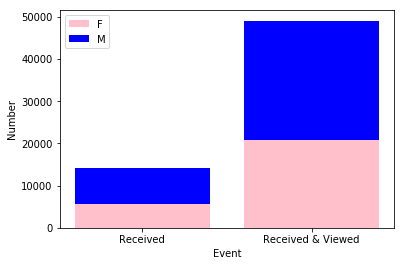

In [285]:
# Gender impact on viewing the offers
from matplotlib import pyplot
gender_count = viewed_received_df.groupby(["event", "gender"]).size()
print(gender_count)
male_stats = [gender_count[0][1],gender_count[1][1]]
female_stats = [gender_count[0][0],gender_count[1][0]]
events = ["Received","Received & Viewed"]
pyplot.bar(events, female_stats, bottom=None, color='pink', label='F')
pyplot.bar(events, male_stats, bottom=[gender_count[0][0],gender_count[1][0]], color='blue', label='M')
pyplot.legend()
pyplot.xlabel('Event')
pyplot.ylabel('Number')

It can be seen that both females and males responds almost equally to an offer received to view it. Males have a slightly more number that can be because of the more male registrations.

In [225]:
# for help
viewed_received_df.columns

Index(['event', 'customerid', 'offerid', 'gender', 'income',
       'established_customers', 'old_customers', 'recent_customers',
       'matured_age', 'millenial_age', 'old_age', 'teen_age', 'difficulty',
       'duration', 'reward', 'bogo', 'discount', 'informational', 'email',
       'mobile', 'social', 'web', 'id'],
      dtype='object')

Text(0, 0.5, 'Number')

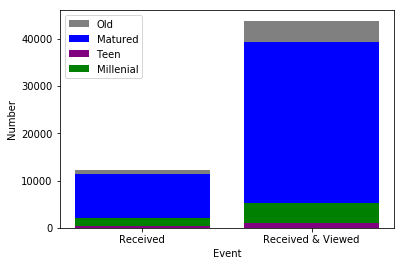

In [229]:
# impact of age on viewing the offers
matured_age_count = viewed_received_df.groupby(["event", "matured_age"]).size()
millenial_age_count = viewed_received_df.groupby(["event", "millenial_age"]).size()
old_age_count = viewed_received_df.groupby(["event", "old_age"]).size()
teen_age_count = viewed_received_df.groupby(["event", "teen_age"]).size()

# as these are hot encoded vectors, we are only interested in values where the values are '1'
matured_age_num = [matured_age_count[0][1], matured_age_count[1][1]]
millenial_age_num = [millenial_age_count[0][1], millenial_age_count[1][1]]
old_age_num = [old_age_count[0][1], old_age_count[1][1]]
teen_age_num = [teen_age_count[0][1], teen_age_count[1][1]]

events = ["Received","Received & Viewed"]
pyplot.bar(events, old_age_num, bottom=matured_age_num, color='grey', label='Old')
pyplot.bar(events, matured_age_num, bottom=millenial_age_num, color='blue', label='Matured')
pyplot.bar(events, teen_age_num, bottom=None, color='purple', label='Teen')
pyplot.bar(events, millenial_age_num, bottom=teen_age_num, color='green', label='Millenial')
pyplot.legend()
pyplot.xlabel('Event')
pyplot.ylabel('Number')

It can be clearly seen that the matured population : 30-70 years old constitute the majority of people who receive and view the offers. It will be a better idea to talk about the ratio of received and viewed to received

Text(0, 0.5, 'Number')

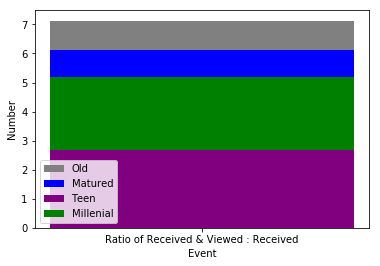

In [230]:
matured_age_count = viewed_received_df.groupby(["event", "matured_age"]).size()
millenial_age_count = viewed_received_df.groupby(["event", "millenial_age"]).size()
old_age_count = viewed_received_df.groupby(["event", "old_age"]).size()
teen_age_count = viewed_received_df.groupby(["event", "teen_age"]).size()

# as these are hot encoded vectors, we are only interested in values where the values are '1'
matured_age_num = [matured_age_count[1][1]/matured_age_count[0][1]]
millenial_age_num = [ millenial_age_count[1][1]/millenial_age_count[0][1]]
old_age_num = [old_age_count[1][1]/old_age_count[0][1]]
teen_age_num = [teen_age_count[1][1]/teen_age_count[0][1]]

events = ["Ratio of Received & Viewed : Received"]
pyplot.bar(events, old_age_num, bottom=matured_age_num, color='grey', label='Old')
pyplot.bar(events, matured_age_num, bottom=millenial_age_num, color='blue', label='Matured')
pyplot.bar(events, teen_age_num, bottom=None, color='purple', label='Teen')
pyplot.bar(events, millenial_age_num, bottom=teen_age_num, color='green', label='Millenial')
pyplot.legend()
pyplot.xlabel('Event')
pyplot.ylabel('Number')

The figure indicates high interest from millenials and teenagers towards viewing the offers

Text(0, 0.5, 'Number')

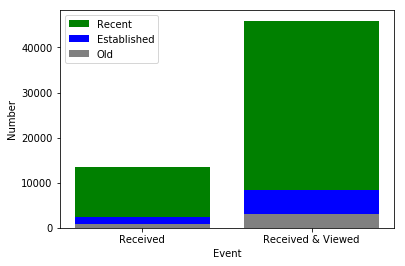

In [232]:
#impact of joining date of customers
established_count = viewed_received_df.groupby(["event", "established_customers"]).size()
old_count = viewed_received_df.groupby(["event", "old_customers"]).size()
recent_count = viewed_received_df.groupby(["event", "recent_customers"]).size()

# as these are hot encoded vectors, we are only interested in values where the values are '1'
established_num = [established_count[0][1], established_count[1][1]]
old_num = [old_count[0][1], old_count[1][1]]
recent_num = [recent_count[0][1], recent_count[1][1]]

events = ["Received", "Received & Viewed"]
pyplot.bar(events, recent_num, bottom=established_num, color='green', label='Recent')
pyplot.bar(events, established_num, bottom=old_num, color='blue', label='Established')
pyplot.bar(events, old_num, bottom=None, color='grey', label='Old')
pyplot.legend()
pyplot.xlabel('Event')
pyplot.ylabel('Number')

All type of customers can be seen to respond in similar numbers. As the number of recent joinees is higher, so is the offers viewed by them.

Text(0, 0.5, 'Number')

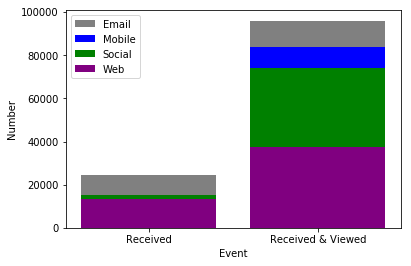

In [284]:
#impact of channel
email_count = viewed_received_df.groupby(["event", "email"]).size()
mobile_count = viewed_received_df.groupby(["event", "mobile"]).size()
social_count = viewed_received_df.groupby(["event", "social"]).size()
web_count = viewed_received_df.groupby(["event", "web"]).size()

# as these are hot encoded vectors, we are only interested in values where the values are '1'
email_num = [email_count[0][1], email_count[1][1]]
mobile_num = [mobile_count[0][1], mobile_count[1][1]]
social_num = [social_count[0][1], social_count[1][1]]
web_num = [web_count[0][1], web_count[1][1]]

events = ["Received","Received & Viewed"]
pyplot.bar(events, email_num, bottom=mobile_num, color='grey', label='Email')
pyplot.bar(events, mobile_num, bottom=social_num, color='blue', label='Mobile')
pyplot.bar(events, social_num, bottom=web_num, color='green', label='Social')
pyplot.bar(events, web_num, bottom=None, color='purple', label='Web')
pyplot.legend()
pyplot.xlabel('Event')
pyplot.ylabel('Number')

Interesting analysis from this plot:
1. Email is not as affective as other channels for sending the offers
2. Mobile is the channel where almost every offer is viewed
3. More Offers can be experimented on social sites more to see the results as social platforms generated good views


Text(0, 0.5, 'Number')

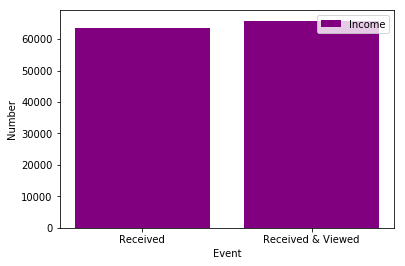

In [247]:
# income analysis
average_income_r = viewed_received_df[viewed_received_df['event']==0]['income'].mean()
average_income_v = viewed_received_df[viewed_received_df['event']==1]['income'].mean()
events = ["Received","Received & Viewed"]
pyplot.bar(events, [average_income_r,average_income_v], bottom=None, color='purple', label='Income')
pyplot.legend()
pyplot.xlabel('Event')
pyplot.ylabel('Number')

The figure indicates that the average income of those who view the offers is very slightly higher than those who don't

In [239]:
# Views vs Completed

## The second analysis: Viewed vs Completed 

Text(0, 0.5, 'Number')

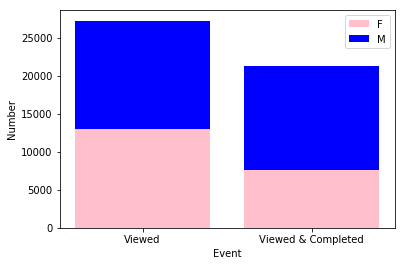

In [286]:
#gender impact on completion of offer
gender_count = completed_viewed_df.groupby(["event", "gender"]).size()
female_stats = [gender_count[0][0],gender_count[1][0]]
male_stats = [gender_count[0][1],gender_count[1][1]]
events = ["Viewed","Viewed & Completed"]
pyplot.bar(events,female_stats , bottom=None, color='pink', label='F')
pyplot.bar(events, male_stats, bottom=[gender_count[0][0],gender_count[1][0]], color='blue', label='M')
pyplot.legend()
pyplot.xlabel('Event')
pyplot.ylabel('Number')

It can be seen that males tend to complete the offer after vieweing more likely than females.

Text(0, 0.5, 'Number')

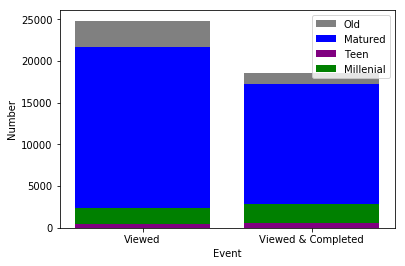

In [243]:
# impact of age on completing the offers
matured_age_count = completed_viewed_df.groupby(["event", "matured_age"]).size()
millenial_age_count = completed_viewed_df.groupby(["event", "millenial_age"]).size()
old_age_count = completed_viewed_df.groupby(["event", "old_age"]).size()
teen_age_count = completed_viewed_df.groupby(["event", "teen_age"]).size()

# as these are hot encoded vectors, we are only interested in values where the values are '1'
matured_age_num = [matured_age_count[0][1], matured_age_count[1][1]]
millenial_age_num = [millenial_age_count[0][1], millenial_age_count[1][1]]
old_age_num = [old_age_count[0][1], old_age_count[1][1]]
teen_age_num = [teen_age_count[0][1], teen_age_count[1][1]]

events = ["Viewed","Viewed & Completed"]
pyplot.bar(events, old_age_num, bottom=matured_age_num, color='grey', label='Old')
pyplot.bar(events, matured_age_num, bottom=millenial_age_num, color='blue', label='Matured')
pyplot.bar(events, teen_age_num, bottom=None, color='purple', label='Teen')
pyplot.bar(events, millenial_age_num, bottom=teen_age_num, color='green', label='Millenial')
pyplot.legend()
pyplot.xlabel('Event')
pyplot.ylabel('Number')

Similar to our analysis for receiving vs vieweing of the offers, as the number of matured age group is high, they actively complete the offers. The old age group is less interested in completing the offers, as the number of old people who viewed and completed as compared to old people those who viewed is low.

Text(0, 0.5, 'Number')

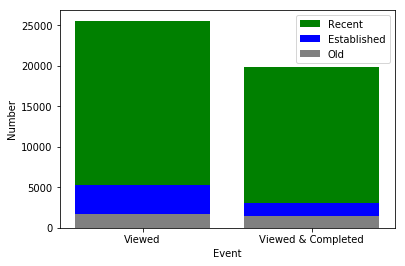

In [244]:
#impact of joining data of customers on completing the offers
established_count = completed_viewed_df.groupby(["event", "established_customers"]).size()
old_count = completed_viewed_df.groupby(["event", "old_customers"]).size()
recent_count = completed_viewed_df.groupby(["event", "recent_customers"]).size()

# as these are hot encoded vectors, we are only interested in values where the values are '1'
established_num = [established_count[0][1], established_count[1][1]]
old_num = [old_count[0][1], old_count[1][1]]
recent_num = [recent_count[0][1], recent_count[1][1]]

events = ["Viewed","Viewed & Completed"]
pyplot.bar(events, recent_num, bottom=established_num, color='green', label='Recent')
pyplot.bar(events, established_num, bottom=old_num, color='blue', label='Established')
pyplot.bar(events, old_num, bottom=None, color='grey', label='Old')
pyplot.legend()
pyplot.xlabel('Event')
pyplot.ylabel('Number')

The plot shows that the old customers are more active in offer completion as compared to established customers. Due to the large number of recent joinees, almost half of them are active in completing the offers.

Text(0, 0.5, 'Number')

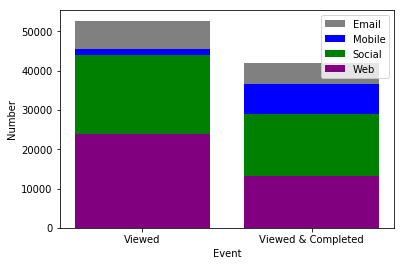

In [283]:
#impact of channel on completion of offer
email_count = completed_viewed_df.groupby(["event", "email"]).size()
mobile_count = completed_viewed_df.groupby(["event", "mobile"]).size()
social_count = completed_viewed_df.groupby(["event", "social"]).size()
web_count = completed_viewed_df.groupby(["event", "web"]).size()

# as these are hot encoded vectors, we are only interested in values where the values are '1'
email_num = [email_count[0][1], email_count[1][1]]
mobile_num = [mobile_count[0][1], mobile_count[1][1]]
social_num = [social_count[0][1], social_count[1][1]]
web_num = [web_count[0][1], web_count[1][1]]

events = ["Viewed","Viewed & Completed"]
pyplot.bar(events, email_num, bottom=mobile_num, color='grey', label='Email')
pyplot.bar(events, mobile_num, bottom=social_num, color='blue', label='Mobile')
pyplot.bar(events, social_num, bottom=web_num, color='green', label='Social')
pyplot.bar(events, web_num, bottom=None, color='purple', label='Web')
pyplot.legend()
pyplot.xlabel('Event')
pyplot.ylabel('Number')

It can be clearly seen, that in social platforms, almost half the offers are viewed and completed. As compared to previous analysis of viewing vs receiving, we also found out that it is not being much utilised by advertisers. Social platforms can be used for better completion rates.

In web advertisements, there are lesser chances of the offers being actually availed and completed. 

Text(0, 0.5, 'Number')

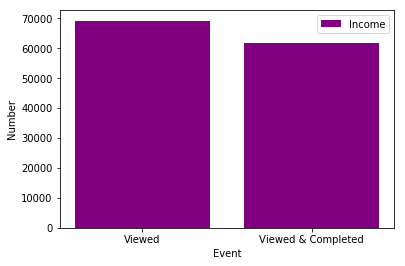

In [248]:
# income analysis
average_income_r = completed_viewed_df[completed_viewed_df['event']==0]['income'].mean()
average_income_v = completed_viewed_df[completed_viewed_df['event']==1]['income'].mean()
events = ["Viewed","Viewed & Completed"]
pyplot.bar(events, [average_income_r,average_income_v], bottom=None, color='purple', label='Income')
pyplot.legend()
pyplot.xlabel('Event')
pyplot.ylabel('Number')

Suprisingly, the average income of those who view the offer and complete is slightly less than, those who leave the offers after viewing. 

Text(0, 0.5, 'Number')

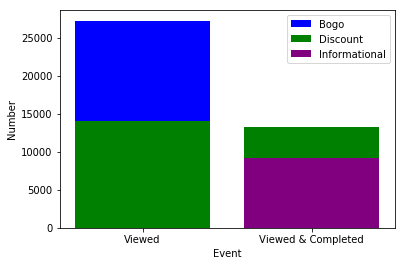

In [282]:
#impact of offer type on completion of offer
bogo_count = completed_viewed_df.groupby(["event", "bogo"]).size()
discount_count = completed_viewed_df.groupby(["event", "discount"]).size()
informational_count= completed_viewed_df.groupby(["event", "informational"]).size()

# as these are hot encoded vectors, we are only interested in values where the values are '1'
bogo_num = [bogo_count[0][1], bogo_count[1][1]]
discount_num = [discount_count[0][1], discount_count[1][1]]
#while running this cell, it was found that there are no informational offers that aren't completed
informational_num = [0, informational_count[1][1]]

events = ["Viewed","Viewed & Completed"]
pyplot.bar(events, bogo_num, bottom=discount_num, color='blue', label='Bogo')
pyplot.bar(events, discount_num, bottom=informational_num, color='green', label='Discount')
pyplot.bar(events, informational_num, bottom=None, color='purple', label='Informational')
pyplot.legend()
pyplot.xlabel('Event')
pyplot.ylabel('Number')

Here, it can be observed that all informational offers are viewed and completed. On the other hand, BOGO offers don't seem to be completed after vieweing. This might be because BOGO offers along with discount offers could have been availed by users without viewing the offers.

Text(0, 0.5, 'Number')

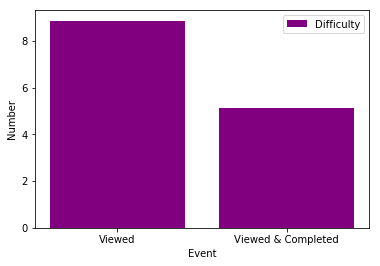

In [256]:
# difficulty analysis
average_diff_v = completed_viewed_df[completed_viewed_df['event']==0]['difficulty'].mean()
average_diff_c = completed_viewed_df[completed_viewed_df['event']==1]['difficulty'].mean()
events = ["Viewed","Viewed & Completed"]
pyplot.bar(events, [average_diff_v,average_diff_c], bottom=None, color='purple', label='Difficulty')
pyplot.legend()
pyplot.xlabel('Event')
pyplot.ylabel('Number')

The difficulty of the offers that are completed after vieweing is lower than those who are not after viewing.

Text(0, 0.5, 'Number')

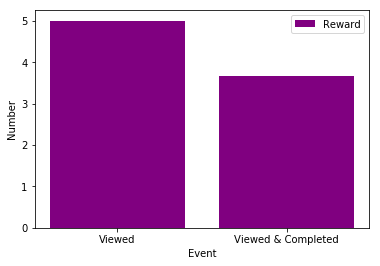

In [257]:
# reward analysis
average_rew_v = completed_viewed_df[completed_viewed_df['event']==0]['reward'].mean()
average_rew_c = completed_viewed_df[completed_viewed_df['event']==1]['reward'].mean()
events = ["Viewed","Viewed & Completed"]
pyplot.bar(events, [average_rew_v,average_rew_c], bottom=None, color='purple', label='Reward')
pyplot.legend()
pyplot.xlabel('Event')
pyplot.ylabel('Number')

The reward of the offers that are completed after vieweing is also lower than those who are not after viewing.

Text(0, 0.5, 'Number')

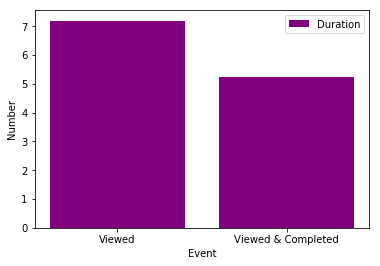

In [258]:
# duration analysis
average_dur_v = completed_viewed_df[completed_viewed_df['event']==0]['duration'].mean()
average_dur_c = completed_viewed_df[completed_viewed_df['event']==1]['duration'].mean()
events = ["Viewed","Viewed & Completed"]
pyplot.bar(events, [average_dur_v,average_dur_c], bottom=None, color='purple', label='Duration')
pyplot.legend()
pyplot.xlabel('Event')
pyplot.ylabel('Number')

As suggested by the last three figures, offers with less difficulty, and duration even with a compromised lower reward are more likely to get completed